In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import collections
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report,confusion_matrix, plot_confusion_matrix

sns.set() # Setar a utilização do seaborn para demonstrar o gráfico.

In [2]:
df = pd.read_excel('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

In [3]:
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [4]:
df[df['PATIENT_VISIT_IDENTIFIER'] == 1]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.00000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.79798,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1


- Informação demográfica - 3 variáveis
- Doenças pré-existentes - 9 variáveis
- Resultados do exame de sangue - 36 variáveis
- Sinais vitais - 6 variáveis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


In [6]:
df.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
len(df['PATIENT_VISIT_IDENTIFIER'].unique())

385

<AxesSubplot:>

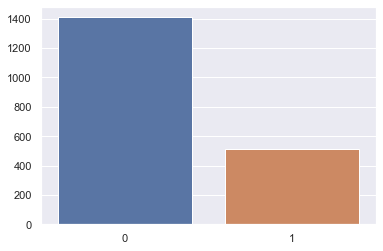

In [8]:
sns.barplot(data=df[['ICU']].value_counts())

In [9]:
x_columns = df.describe().columns

In [10]:
df_limpos = df[x_columns]

In [11]:
df_limpos = df_limpos.dropna()

In [12]:
df_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
4,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,1
6,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
8,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.764706,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,1
9,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.764706,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,1
14,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.705882,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,1


In [13]:
df_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
4,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,1
6,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
8,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.764706,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,1
9,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.764706,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,1
14,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.705882,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,1


In [14]:
X = df_limpos.drop('ICU',axis=1)
y = df_limpos['ICU']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
modelo = LogisticRegression()

In [17]:
modelo.fit(X_train, y_train)

LogisticRegression()

In [18]:
prediction = modelo.predict(X_test)

In [19]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        74
           1       0.91      0.79      0.85        63

    accuracy                           0.87       137
   macro avg       0.88      0.86      0.87       137
weighted avg       0.87      0.87      0.87       137



In [20]:
importance = modelo.coef_[0]
colunas_importantes = []

for i,v in enumerate(importance):
    if (v > 0.5):
        colunas_importantes.append(i)

In [21]:
colunas_importantes

[193, 195, 199, 201, 211, 213, 219, 225]

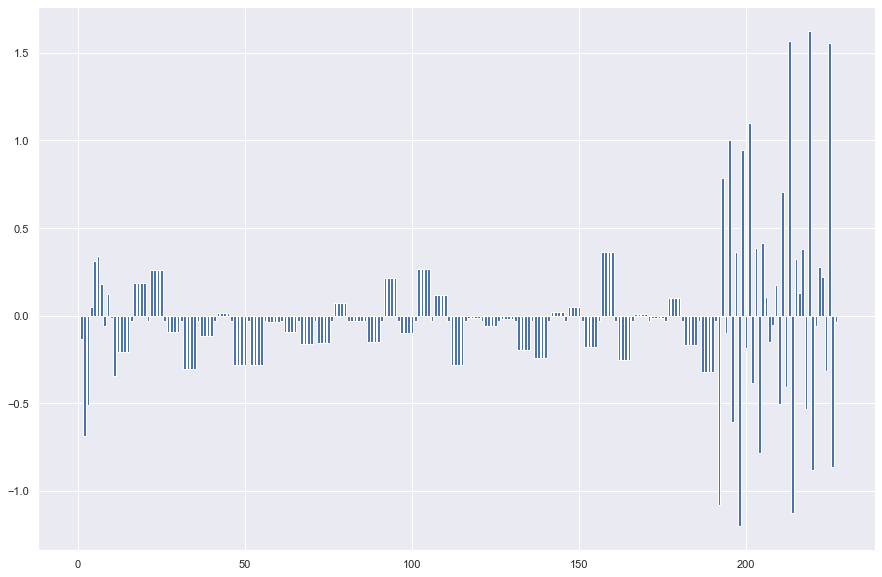

In [22]:
# plot feature importance

plt.figure(figsize=(15,10))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [23]:
X = df_limpos[df_limpos.columns[colunas_importantes]]
y = df_limpos['ICU']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
modelo = LogisticRegression()

In [26]:
modelo.fit(X_train, y_train)

LogisticRegression()

In [27]:
prediction = modelo.predict(X_test)

In [28]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91        88
           1       0.93      0.84      0.88        76

    accuracy                           0.90       164
   macro avg       0.90      0.89      0.89       164
weighted avg       0.90      0.90      0.90       164



In [5]:
df = pd.read_excel('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

In [6]:
print(list(df.columns))

['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN', 'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF', 'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATI

In [7]:
remover = df.query("WINDOW == '0-2' and ICU == 1")['PATIENT_VISIT_IDENTIFIER'].values

In [8]:
df_limpos = df.query("PATIENT_VISIT_IDENTIFIER not in  @remover")
df_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [9]:
def preenchertabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas , saida], ignore_index=True, axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [10]:
df_limpos = preenchertabela(df_limpos)
df_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [11]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2','ICU'] = 1
    return rows.loc[rows['WINDOW']=='0-2']

In [12]:
df_limpos = df_limpos.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False ).apply(prepare_window)
df_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


In [13]:
df_limpos = df_limpos.dropna()

In [14]:
df_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,...,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,192.818182,0.457386,0.380682,0.105114,0.022727,0.090909,0.019886,0.127841,0.042614,0.193182,...,-0.962066,-0.965233,-0.985365,-0.963091,-0.958921,-0.976421,-0.964390,-0.965725,-0.985390,0.463068
std,110.763735,0.498890,0.486246,0.307136,0.149245,0.287889,0.139809,0.334388,0.202272,0.395356,...,0.110411,0.086132,0.032640,0.106132,0.117561,0.059606,0.095115,0.084306,0.033025,0.499344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,97.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,191.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,289.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-0.979798,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980333,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.058824,-0.238095,-0.757576,0.130435,0.378657,-0.535878,-0.268817,-0.285468,-0.732438,1.000000


In [15]:
labelencoder = LabelEncoder()

df_limpos['AGE_PERCENTIL'] = labelencoder.fit_transform(df_limpos['AGE_PERCENTIL'])

In [39]:
#age_percentil = pd.get_dummies(df_limpos['AGE_PERCENTIL'],drop_first=True)

In [16]:
df_limpos.drop(['PATIENT_VISIT_IDENTIFIER','WINDOW'], axis=1, inplace=True)

In [41]:
#df_limpos = pd.concat([df_limpos, age_percentil],axis=1)

In [17]:
X = df_limpos.drop('ICU',axis=1)
y = df_limpos['ICU']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [19]:
modelo = LogisticRegression()

In [20]:
modelo.fit(X_train, y_train)

LogisticRegression()

In [21]:
prediction = modelo.predict(X_test)

In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79        47
           1       0.78      0.68      0.73        41

    accuracy                           0.76        88
   macro avg       0.76      0.76      0.76        88
weighted avg       0.76      0.76      0.76        88



In [23]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBClassifier": XGBClassifier()
}

In [ ]:

# Usa GridSearchCV para encontrar os melhores parametros.
from sklearn.model_selection import GridSearchCV

#XGBClassifier 
xgboost_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

grid_xgboost = GridSearchCV(XGBClassifier(eval_metric='mlogloss'), xgboost_params)
grid_xgboost.fit(X_train, y_train)

xgboost = grid_xgboost.best_estimator_


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_


In [ ]:

xgboost_score = cross_val_score(xgboost, X_train, y_train, cv=5)
print('Xgboost Cross Validation Score: ', round(xgboost_score.mean() * 100, 2).astype(str) + '%')


log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


In [49]:
xgbmodel = XGBClassifier(eval_metric='mlogloss')

In [50]:
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [51]:
prediction = xgbmodel.predict(X_test)

In [52]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80        47
           1       0.80      0.68      0.74        41

    accuracy                           0.77        88
   macro avg       0.78      0.77      0.77        88
weighted avg       0.78      0.77      0.77        88



In [53]:
#xgboost.fit(X_train, y_train)

In [54]:
#prediction = xgboost.predict(X_test)

In [55]:
#print(classification_report(y_test,prediction))

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from numpy import sort
from sklearn.feature_selection import SelectFromModel

y_pred = xgboost.predict(X_test)
predictions = [round(value) for value in y_pred]
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
print("Recall: %.2f%%" % (recall * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))

thresholds = sort(xgboost.feature_importances_)
for thresh in thresholds:

    selection = SelectFromModel(xgboost, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)

    selection_model = XGBClassifier(eval_metric='mlogloss')
    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Recall: %.2f%%" % (thresh, select_X_train.shape[1], recall*100.0))
    print("Thresh=%.3f, n=%d, Precision: %.2f%%" % (thresh, select_X_train.shape[1], precision*100.0))

Text(0.5, 1.0, 'Importância de cada feature')

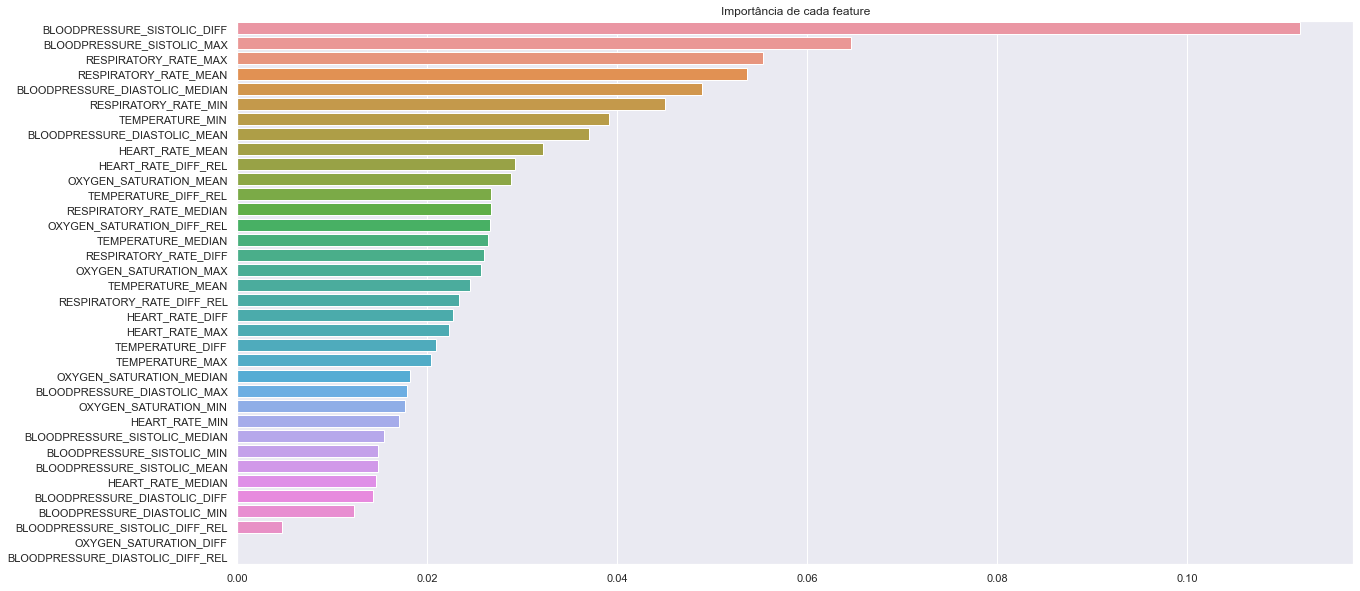

In [91]:
plt.figure(figsize=(20,10))
importances = pd.Series(data=xgbmodel.feature_importances_ , index=X_train.columns).sort_values(ascending=False).head(70)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA(n_components=2)

In [59]:
x_pca = pca.fit_transform(df_limpos)

In [60]:
df_limpos.shape

(352, 237)

In [61]:
x_pca.shape

(352, 2)

Text(0, 0.5, 'Second Principal Component')

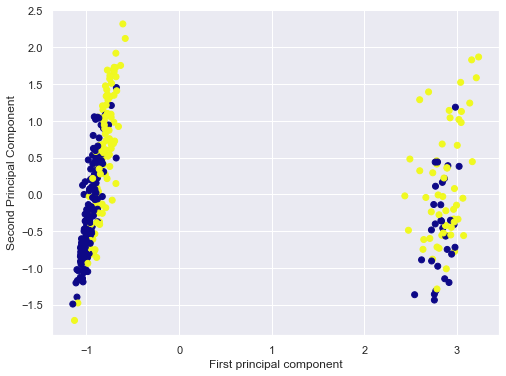

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df_limpos['ICU'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [63]:
pca.components_

array([[ 3.55045572e-02,  8.08617816e-04,  1.13618991e-02,
         1.26931808e-03,  2.29376770e-03,  1.03629091e-03,
         8.19285673e-05, -6.95578793e-03,  1.46000575e-02,
         1.76951791e-02,  2.81138925e-02, -1.05611766e-02,
        -1.05611766e-02, -1.05611766e-02, -1.05611766e-02,
        -0.00000000e+00,  2.01671890e-03,  2.01671890e-03,
         2.01671890e-03,  2.01671890e-03, -5.73971851e-42,
         2.01773245e-02,  2.01773245e-02,  2.01773245e-02,
         2.01773245e-02, -0.00000000e+00,  1.63223819e-03,
         1.63223819e-03,  1.63223819e-03,  1.63223819e-03,
        -0.00000000e+00,  3.60530949e-03,  3.60530949e-03,
         3.60530949e-03,  3.60530949e-03, -0.00000000e+00,
         3.57911909e-04,  3.57911909e-04,  3.57911909e-04,
         3.57911909e-04, -0.00000000e+00, -1.75042594e-03,
        -1.75042594e-03, -1.75042594e-03, -1.75042594e-03,
        -0.00000000e+00, -1.16575614e-02, -1.16575614e-02,
        -1.16575614e-02, -1.16575614e-02, -0.00000000e+0

In [64]:
df_comp = pd.DataFrame(pca.components_,columns=df_limpos.columns)

<AxesSubplot:>

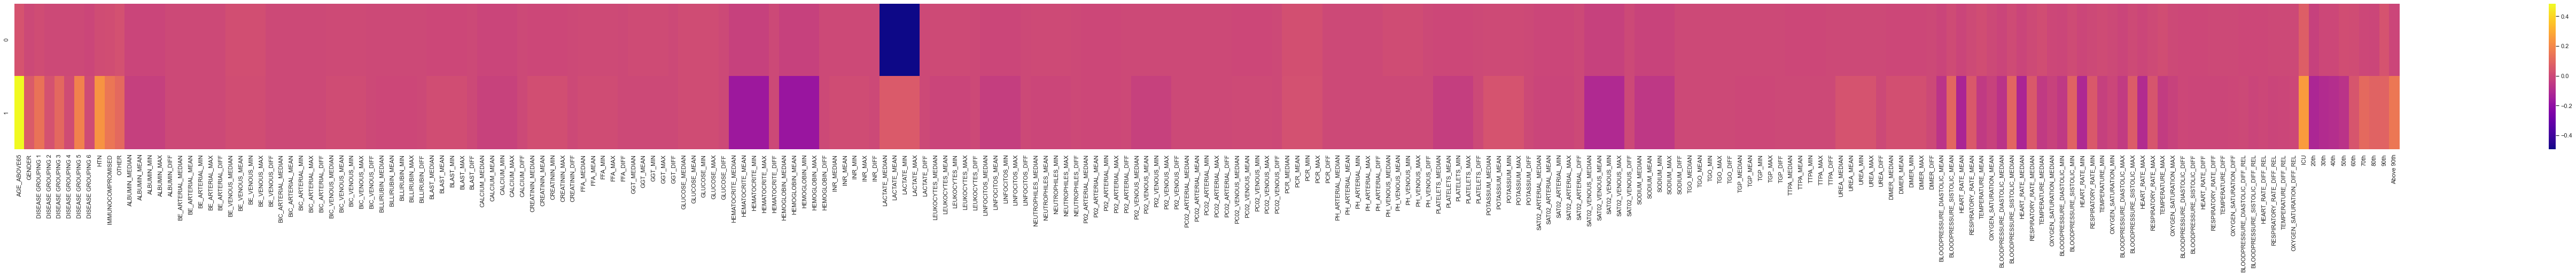

In [65]:
plt.figure(figsize=(100,5))
sns.heatmap(df_comp,cmap='plasma',)

In [66]:
df_limpos.iloc[:, 13:-2]

,,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,...,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,20th,30th,40th,50th,60th,70th,80th
0,0,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,1,0,0,0,0,1,0,0
1,10,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-0.961262,1,0,0,0,0,0,0,0
2,15,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,0,0,0,1,0,0,0,0
3,20,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-0.953536,-0.980333,0,0,0,0,0,0,0,0
4,25,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-0.975891,-0.980129,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1900,-0.578947,-0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,1,0,0,1,0,0,0,0
349,1905,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-0.612627,-1.000000,0,0,0,0,0,0,0,0
350,1910,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,1,0,0,0,1,0,0,0
351,1915,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,0,0,0,1,0,0,0,0


<AxesSubplot:>

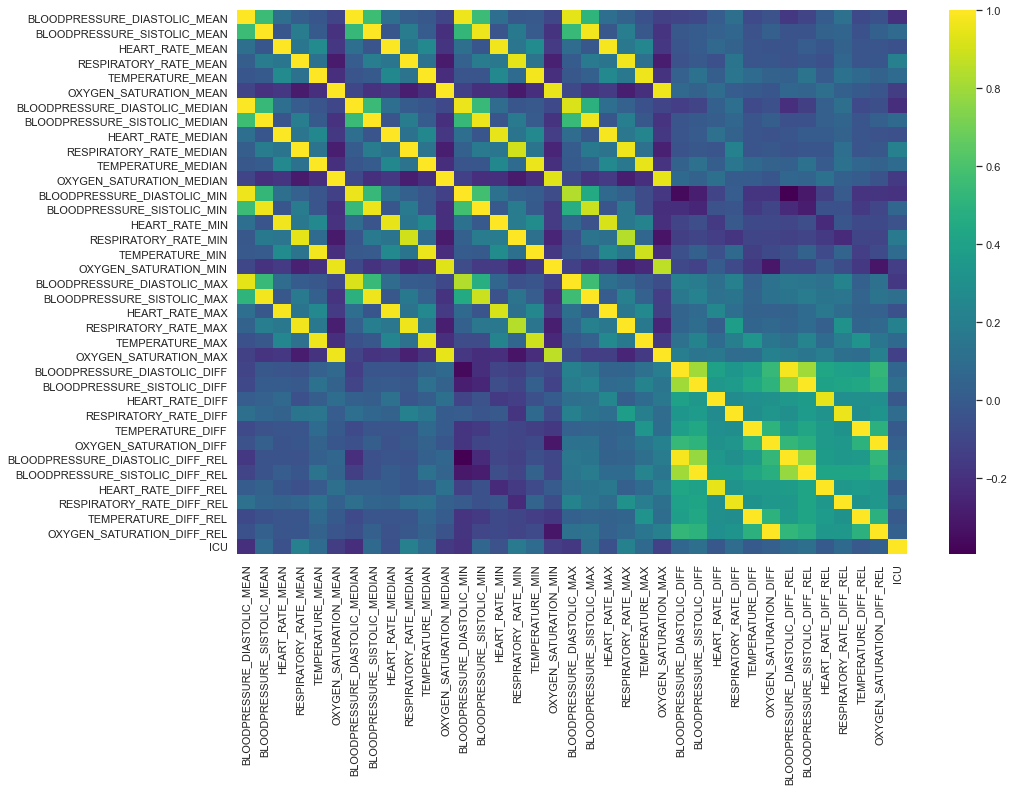

In [67]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_limpos.iloc[:, -46:-9].corr(),cmap='viridis')

<AxesSubplot:>

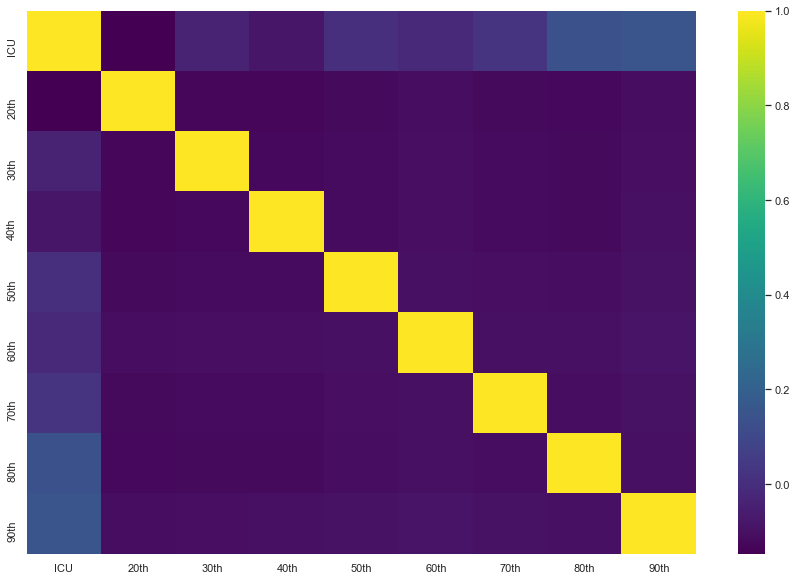

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_limpos.iloc[:, -10:-1].corr(),cmap='viridis')

In [69]:
frequencia = pd.crosstab(df['ICU'],
                         df['AGE_PERCENTIL'])
frequencia.rename(index = df['ICU'], inplace = True)
frequencia.rename(columns = df['AGE_PERCENTIL'], inplace = True)
frequencia

AGE_PERCENTIL,10th,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th
ICU,,,,,,,,,,
0,179,186,160,166,145,128,127,128,92,99
0,26,29,45,34,45,57,68,62,63,86


In [70]:
df['AGE_PERCENTIL'].value_counts()

20th          215
10th          205
30th          205
40th          200
70th          195
50th          190
80th          190
60th          185
Above 90th    185
90th          155
Name: AGE_PERCENTIL, dtype: int64

In [71]:
df_limpos.iloc[:, -46:-9]

,,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,10,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,15,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,20,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,25,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.037037,-0.538462,-0.537736,-0.517241,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1900,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.160494,-0.692308,0.339623,-0.448276,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
349,1905,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.407407,-0.692308,-0.283019,-0.448276,...,-1.000000,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0
350,1910,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,0.012346,-0.384615,-0.320755,-0.448276,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
351,1915,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,0.086420,-0.230769,-0.301887,-0.655172,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0


In [72]:
X = df_limpos.iloc[:, -46:-9].drop('ICU',axis=1)
y = df_limpos.iloc[:, -46:-9]['ICU']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [74]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

LogisticRegression()

In [75]:
prediction = modelo.predict(X_test)

In [76]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.65      0.81      0.72        48
           1       0.68      0.47      0.56        40

    accuracy                           0.66        88
   macro avg       0.66      0.64      0.64        88
weighted avg       0.66      0.66      0.65        88



In [81]:
xgbmodel = XGBClassifier(eval_metric='mlogloss')
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [82]:
prediction = xgbmodel.predict(X_test)

In [83]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65        48
           1       0.56      0.47      0.51        40

    accuracy                           0.59        88
   macro avg       0.58      0.58      0.58        88
weighted avg       0.59      0.59      0.59        88



In [85]:
df_limpos['ICU'].value_counts()

0    189
1    163
Name: ICU, dtype: int64

<AxesSubplot:xlabel='ICU', ylabel='OXYGEN_SATURATION_MEDIAN'>

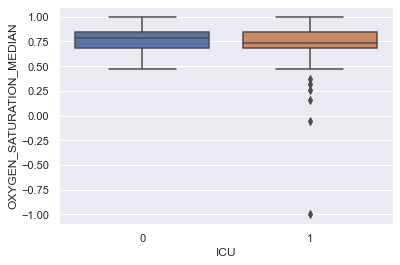

In [88]:
sns.boxplot(x='ICU', y='OXYGEN_SATURATION_MEDIAN', data=df_limpos)

<AxesSubplot:xlabel='ICU', ylabel='BLOODPRESSURE_DIASTOLIC_DIFF'>

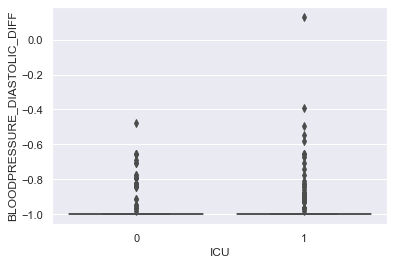

In [92]:
sns.boxplot(x='ICU', y='BLOODPRESSURE_DIASTOLIC_DIFF', data=df_limpos)

In [24]:
df_limpos.head()

,,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,10,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,15,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,20,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,25,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


In [4]:
list(range(2,200,1))

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 1